# Notebook Approche Non Supervisé

## Functions

In [35]:
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd

def evaluate_and_log_metrics(experiment_name, lda_model, corpus_test_selected, text_data_test, dictionary_train_selected, model_type, training_time = None):

    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment is None:
        mlflow.create_experiment(experiment_name)
        experiment = mlflow.get_experiment_by_name(experiment_name)

    log_perplexity = lda_model.log_perplexity(corpus_test_selected)
    perplexity = np.exp2(-log_perplexity)

    coherence_model = CoherenceModel(model=lda_model, texts=text_data_test, dictionary=dictionary_train_selected, coherence='c_v')
    
    coherence_score = coherence_model.get_coherence()

    with mlflow.start_run(experiment_id=experiment.experiment_id):
        mlflow.log_param("model_type", model_type)
        mlflow.log_metric("Log-Perplexity", log_perplexity)
        mlflow.log_metric("Perplexity", perplexity)
        mlflow.log_metric("Coherence", coherence_score)
        if (training_time != None):
            mlflow.log_metric("training_time", training_time)

    return log_perplexity, perplexity, coherence_score

## Split dataset

In [36]:
from sklearn.model_selection import train_test_split

data = pd.read_csv("dataset_cleaned.csv")
train_data, test_data = train_test_split(data, test_size=0.2)

## LDA (Latent Dirichlet allocation)

### Préparer LDA sur les titres (pour un modèle simple)

In [37]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary

# train
text_data_train_title = [[word.strip("[]'") for word in doc.split(', ')] for doc in train_data['title_lemmatized']]

text_data_train_title = [[word for phrase in doc for word in phrase.split()] for doc in text_data_train_title]

# test
text_data_test_title = [[word.strip("[]'") for word in doc.split(', ')] for doc in test_data['title_lemmatized']]

text_data_test_title = [[word for phrase in doc for word in phrase.split()] for doc in text_data_test_title]

dictionary_train_title = Dictionary(text_data_train_title)
corpus_train_title = [dictionary_train_title.doc2bow(word_list) for word_list in text_data_train_title]

corpus_test_title = [dictionary_train_title.doc2bow(word_list) for word_list in text_data_test_title]

# Entraînement du modèle LDA sur le train set
lda_model_title = LdaModel(corpus_train_title, num_topics=5, id2word=dictionary_train_title, passes=10)

# mots associés à chaque topic pour le titre
print("Mots associés à chaque topic pour le titre:")
for topic_idx, topic in lda_model_title.print_topics():
    print(f"Topic {topic_idx + 1}: {topic}")

log_perplexity_title = lda_model_title.log_perplexity(corpus_test_title)
perplexity_title = np.exp2(-log_perplexity_title)

print(f"Log-Perplexity: {log_perplexity_title}")
print(f"Perplexity: {perplexity_title}")

Mots associés à chaque topic pour le titre:
Topic 1: 0.019*"using" + 0.012*"data" + 0.010*"sql" + 0.009*"file" + 0.009*"use" + 0.009*"line" + 0.008*"pandas" + 0.008*"server" + 0.008*"multiple" + 0.007*"database"
Topic 2: 0.016*"string" + 0.015*"value" + 0.012*"array" + 0.010*"get" + 0.010*"change" + 0.009*"list" + 0.009*"c" + 0.009*"object" + 0.009*"convert" + 0.009*"type"
Topic 3: 0.021*"error" + 0.013*"file" + 0.010*"aspnet" + 0.010*"app" + 0.010*"using" + 0.008*"web" + 0.008*"windows" + 0.008*"android" + 0.008*"build" + 0.008*"spring"
Topic 4: 0.020*"difference" + 0.017*"c" + 0.011*"java" + 0.011*"way" + 0.010*"vs" + 0.010*"whats" + 0.010*"python" + 0.009*"using" + 0.009*"function" + 0.009*"class"
Topic 5: 0.017*"vs" + 0.016*"android" + 0.015*"studio" + 0.011*"visual" + 0.010*"test" + 0.009*"work" + 0.007*"c" + 0.006*"using" + 0.006*"doesnt" + 0.006*"library"
Log-Perplexity: -9.41208977513912
Perplexity: 681.2732615675515


In [38]:
# Afficher les mots correspondant à chaque index dans le premier document
for (index, freq) in corpus_train_title[0]:
    print(f"Mot: {dictionary_train_title[index]}, Fréquence: {freq}")

Mot: connections, Fréquence: 1
Mot: difference, Fréquence: 1
Mot: remotessh, Fréquence: 1
Mot: remotetunnel, Fréquence: 1
Mot: vscode, Fréquence: 1


### Trouver le nombre de topics avec la Perplexité (Avec title seulement)

In [39]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
import numpy as np
from gensim.models import CoherenceModel

# train
text_data_train_title = [[word.strip("[]'") for word in doc.split(', ')] for doc in train_data['title_lemmatized']]

text_data_train_title = [[word for phrase in doc for word in phrase.split()] for doc in text_data_train_title]

# test
text_data_test_title = [[word.strip("[]'") for word in doc.split(', ')] for doc in test_data['title_lemmatized']]

text_data_test_title = [[word for phrase in doc for word in phrase.split()] for doc in text_data_test_title]

dictionary_train_title = Dictionary(text_data_train_title)

dictionary_train_title.filter_extremes(no_below=5, no_above=0.6)

corpus_train_title = [dictionary_train_title.doc2bow(word_list) for word_list in text_data_train_title]
corpus_test_title = [dictionary_train_title.doc2bow(word_list) for word_list in text_data_test_title]

# nombres de topics à tester
num_topics_list = [5, 10, 20, 30, 50, 80, 100]

perplexity_scores = []
coherence_scores = []

for num_topics in num_topics_list:
    lda_model_title = LdaModel(corpus_train_title, num_topics=num_topics, id2word=dictionary_train_title, passes=10)

    log_perplexity_title = lda_model_title.log_perplexity(corpus_test_title)
    perplexity_title = np.exp2(-log_perplexity_title)
    perplexity_scores.append(perplexity_title)

    # score de cohérence
    coherence_model_title = CoherenceModel(model=lda_model_title, texts=text_data_train_title, dictionary=dictionary_train_title, coherence='c_v')
    coherence_score = coherence_model_title.get_coherence()
    coherence_scores.append(coherence_score)

    print("Nombre de Topics:", num_topics)
    print("  Score de Perplexité:", perplexity_title)
    print("  Score de Cohérence:", coherence_score)
    print()

best_num_topics = num_topics_list[np.argmin(perplexity_scores)]
best_num_topics_coh = num_topics_list[np.argmax(coherence_scores)]

print(f"Le nombre optimal de topics selon la perplexité est : {best_num_topics}")
print(f"Le nombre optimal de topics selon la cohérence des topics est : {best_num_topics_coh}")


Nombre de Topics: 5
  Score de Perplexité: 281.22725617496474
  Score de Cohérence: 0.25737948522967696
Nombre de Topics: 10
  Score de Perplexité: 331.24705657083024
  Score de Cohérence: 0.2860502174521859
Nombre de Topics: 20
  Score de Perplexité: 1356.0237749219734
  Score de Cohérence: 0.4029160701088886
Nombre de Topics: 30
  Score de Perplexité: 2946.674976524633
  Score de Cohérence: 0.4798927681075457
Nombre de Topics: 50
  Score de Perplexité: 19951.592721825647
  Score de Cohérence: 0.5774498245025041
Nombre de Topics: 80
  Score de Perplexité: 8457153.733721275
  Score de Cohérence: 0.5619136302341218
Nombre de Topics: 100
  Score de Perplexité: 85082499819.20326
  Score de Cohérence: 0.5667427241564252

Le nombre optimal de topics selon la perplexité est : 5
Le nombre optimal de topics selon la cohérence des topics est : 50


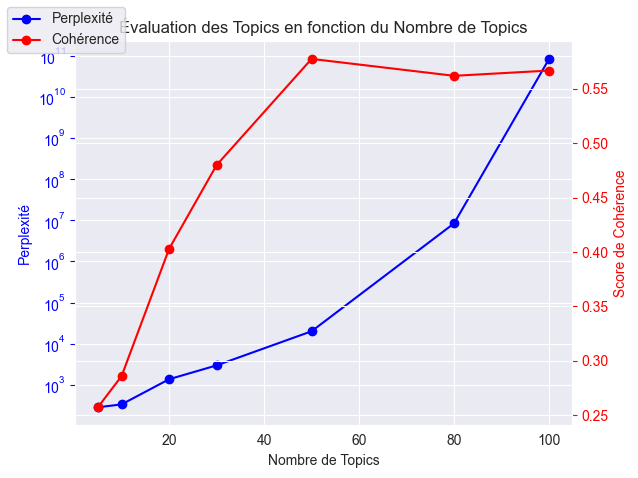

In [40]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.plot(num_topics_list, perplexity_scores, marker='o', linestyle='-', color='b', label='Perplexité')
ax1.set_xlabel('Nombre de Topics')
ax1.set_ylabel('Perplexité', color='b')
ax1.tick_params('y', colors='b')

ax1.set_yscale('symlog')

ax2 = ax1.twinx()

ax2.plot(num_topics_list, coherence_scores, marker='o', linestyle='-', color='r', label='Cohérence')
ax2.set_ylabel('Score de Cohérence', color='r')
ax2.tick_params('y', colors='r')

plt.title('Évaluation des Topics en fonction du Nombre de Topics')
fig.tight_layout()
fig.legend(loc='upper left')

plt.show()


In [41]:
print(corpus_train_title)


[[(0, 1), (1, 1), (2, 1)], [(3, 1), (4, 1), (5, 1), (6, 1)], [(7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)], [(16, 1), (17, 1), (18, 1)], [(19, 1), (20, 1)], [(21, 1), (22, 1), (23, 1), (24, 1)], [(25, 1), (26, 1), (27, 1)], [(28, 1), (29, 1)], [(30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1)], [(37, 1), (38, 1), (39, 1)], [(40, 1), (41, 1), (42, 1)], [(43, 1), (44, 1), (45, 1), (46, 1)], [(16, 1), (18, 1), (47, 1), (48, 1)], [(1, 1)], [(49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1)], [(55, 1), (56, 1), (57, 1), (58, 1)], [(15, 1), (59, 1), (60, 1), (61, 1)], [(62, 1), (63, 1)], [(64, 1), (65, 1)], [(8, 1), (22, 1), (46, 1), (66, 1), (67, 1), (68, 1)], [(69, 1), (70, 1), (71, 1)], [(27, 1), (72, 1)], [(60, 1), (73, 1), (74, 1), (75, 1), (76, 1)], [(77, 1), (78, 1), (79, 1)], [(80, 1), (81, 1), (82, 1), (83, 1), (84, 1)], [(65, 1), (85, 1), (86, 1)], [(87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1)], [(39, 1), (93, 1), (94, 1), (9

### Trouver le nombre de topics avec la Perplexité (Avec title et body)

In [42]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
import numpy as np

# train
text_data_train_title = [[word.strip("[]'") for word in doc.split(', ')] for doc in train_data['title_lemmatized']]
text_data_train_title = [[word for phrase in doc for word in phrase.split()] for doc in text_data_train_title]

text_data_train_body = [[word.strip("[]'") for word in doc.split(', ')] for doc in train_data['body_lemmatized']]
text_data_train_body = [[word for phrase in doc for word in phrase.split()] for doc in text_data_train_body]

text_data_train_combined = [title + body for title, body in zip(text_data_train_title, text_data_train_body)]

# test
text_data_test_title = [[word.strip("[]'") for word in doc.split(', ')] for doc in test_data['title_lemmatized']]
text_data_test_title = [[word for phrase in doc for word in phrase.split()] for doc in text_data_test_title]

text_data_test_body = [[word.strip("[]'") for word in doc.split(', ')] for doc in test_data['body_lemmatized']]
text_data_test_body = [[word for phrase in doc for word in phrase.split()] for doc in text_data_test_body]

text_data_test_combined = [title + body for title, body in zip(text_data_test_title, text_data_test_body)]


dictionary_train_combined = Dictionary(text_data_train_combined)

dictionary_train_combined.filter_extremes(no_below=5, no_above=0.6)

corpus_train_combined = [dictionary_train_combined.doc2bow(word_list) for word_list in text_data_train_combined]
corpus_test_combined = [dictionary_train_combined.doc2bow(word_list) for word_list in text_data_test_combined]

num_topics_list = [5, 10, 20, 30, 50, 80, 100]
perplexity_scores_combined = []
coherence_scores_combined = []

for num_topics in num_topics_list:    
    lda_model_combined = LdaModel(corpus_train_combined, num_topics=num_topics, id2word=dictionary_train_combined, passes=10)

    log_perplexity_combined = lda_model_combined.log_perplexity(corpus_test_combined)
    perplexity_combined = np.exp2(-log_perplexity_combined)
    
    perplexity_scores_combined.append(perplexity_combined)

    # score de cohérence
    coherence_model_combined = CoherenceModel(model=lda_model_combined, texts=text_data_train_combined, dictionary=dictionary_train_combined, coherence='c_v')
    coherence_score_combined = coherence_model_combined.get_coherence()
    coherence_scores_combined.append(coherence_score_combined)

    print("Nombre de Topics:", num_topics)
    print("  Score de Perplexité:", perplexity_combined)
    print("  Score de Cohérence:", coherence_score_combined)
    print()

best_num_topics_combined = num_topics_list[np.argmin(perplexity_scores_combined)]
best_num_topics_coh_combined = num_topics_list[np.argmax(coherence_scores_combined)]

print(f"Le nombre optimal de topics selon la perplexité est : {best_num_topics_combined}")
print(f"Le nombre optimal de topics selon la cohérence des topics est : {best_num_topics_coh_combined}")


Nombre de Topics: 5
  Score de Perplexité: 245.82969144545777
  Score de Cohérence: 0.5174523559241034
Nombre de Topics: 10
  Score de Perplexité: 282.8399182149192
  Score de Cohérence: 0.5589176273723158
Nombre de Topics: 20
  Score de Perplexité: 462.5186758230117
  Score de Cohérence: 0.5349234886577168
Nombre de Topics: 30
  Score de Perplexité: 646.3847210960853
  Score de Cohérence: 0.5460473442065806
Nombre de Topics: 50
  Score de Perplexité: 1287.5014577303737
  Score de Cohérence: 0.5139194609371707
Nombre de Topics: 80
  Score de Perplexité: 3488.4067747449494
  Score de Cohérence: 0.48049299639788573
Nombre de Topics: 100
  Score de Perplexité: 6932.603397564197
  Score de Cohérence: 0.4619662230250804

Le nombre optimal de topics selon la perplexité est : 5
Le nombre optimal de topics selon la cohérence des topics est : 10


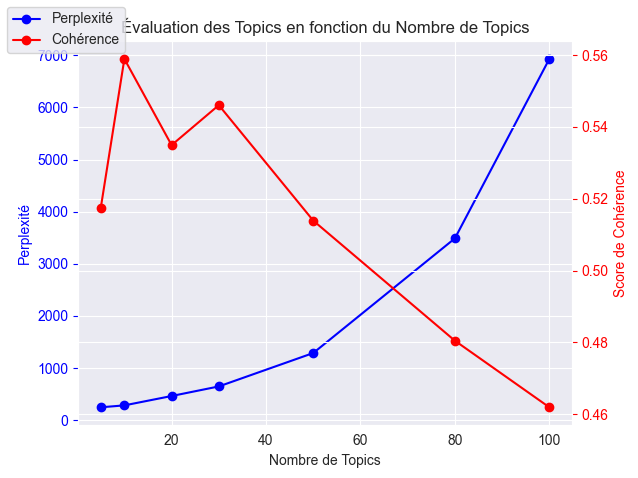

In [43]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.plot(num_topics_list, perplexity_scores_combined, marker='o', linestyle='-', color='b', label='Perplexité')
ax1.set_xlabel('Nombre de Topics')
ax1.set_ylabel('Perplexité', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()

ax2.plot(num_topics_list, coherence_scores_combined, marker='o', linestyle='-', color='r', label='Cohérence')
ax2.set_ylabel('Score de Cohérence', color='r')
ax2.tick_params('y', colors='r')

plt.title('Évaluation des Topics en fonction du Nombre de Topics')
fig.tight_layout()
fig.legend(loc='upper left')

plt.show()


## Sélection du meilleur modèle LDA

In [44]:
from gensim.models import LdaModel
import time

# nombre de mots clés à afficher pour chaque topic
num_words = 30

# nombre de topics
num_topics = 20

start_time = time.time()

# créer un modèle LDA et l'entraîner sur les données
lda_selected = LdaModel(corpus=corpus_train_combined, num_topics=num_topics, id2word=dictionary_train_combined, passes=10,random_state=42)

end_time = time.time()
training_time = end_time - start_time
print("Temps d'entrainement:", training_time, "secondes")

# mots clés pour chaque topic
for topic_idx in range(num_topics):
    print(f"Topic {topic_idx + 1}:")
    print(lda_selected.show_topic(topic_idx, topn=num_words))
    print()


Temps d'entrainement: 62.89905905723572 secondes
Topic 1:
[('error', 0.0324277), ('project', 0.0262587), ('build', 0.02270445), ('file', 0.020214064), ('run', 0.012553286), ('version', 0.012494816), ('files', 0.011145413), ('npm', 0.010306905), ('application', 0.009722432), ('package', 0.00952703), ('dependency', 0.009490584), ('failed', 0.00930175), ('found', 0.009191087), ('info', 0.008740512), ('configuration', 0.008424587), ('dependencies', 0.00807644), ('folder', 0.0076926937), ('debug', 0.007551697), ('log', 0.0069728387), ('using', 0.006892557), ('plugin', 0.00662286), ('add', 0.0066001117), ('err', 0.006510895), ('eclipse', 0.00639193), ('get', 0.0061115427), ('source', 0.00598863), ('following', 0.005912817), ('java', 0.0055400888), ('could', 0.005434974), ('docker', 0.004892769)]

Topic 2:
[('class', 0.036858093), ('type', 0.029726986), ('c', 0.024088476), ('include', 0.014238813), ('foo', 0.012845342), ('template', 0.012349998), ('compile', 0.011314247), ('static', 0.0111941

### Mapping manuel des noms des topics après analyse des corpus

In [45]:
topic_names = {
    0: "mobile-development",
    1: "web",
    2: "java",
    3: "software-design",
    4: "python",
    5: "server-side",
    6: "frameworks",
    7: "code-structure",
    8: "javascript",
    9: "paradigms",
    10: "file-handling",
    11: "ios",
    12: "spring",
    13: "devtools",
    14: "user-interface",
    15: "methodology",
    16: "configuration",
    17: "data-modeling",
    18: "asp.net",
    19: "optimization"
}


### Visualisation des topics avec pyLDAvis

In [46]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# prépare les données pour la visualisation
lda_vis_data = gensimvis.prepare(lda_selected, corpus_train_combined, dictionary_train_combined)

# graphique interactif
pyLDAvis.display(lda_vis_data)


### Prédiction des 5 meilleures catégories / tags

In [47]:
from gensim.utils import simple_preprocess

# prétraiter le texte
def simple_preprocess_text(text):
    return simple_preprocess(text)

# distributions de probabilité des topics pour une phrase donnée
def get_topic_distribution(model, dictionary, text):
    text_tokens = simple_preprocess_text(text)
    text_bow = dictionary.doc2bow(text_tokens)
    return model.get_document_topics(text_bow)

phrase = "Accuracy issue in classification model"

# distributions de probabilité des topics pour la phrase
topic_distribution = get_topic_distribution(lda_selected, dictionary_train_combined, phrase)

# trier les topics par probabilité
sorted_topics = sorted(topic_distribution, key=lambda x: x[1], reverse=True)

# sélectionner les cinq premiers topics
top_5_topics = sorted_topics[:5]

for topic in top_5_topics:
    topic_idx, prob = topic
    topic_name = topic_names.get(topic_idx, f"Topic {topic_idx}")
    print(f"{topic_name}: Probability: {prob}")
    print(lda_selected.show_topic(topic_idx, topn=num_words))
    print()

software-design: Probability: 0.41887983679771423
[('file', 0.08374496), ('string', 0.048083734), ('files', 0.027767327), ('text', 0.022066548), ('output', 0.01897587), ('line', 0.015604783), ('format', 0.015086462), ('using', 0.013656414), ('convert', 0.013446618), ('print', 0.0126462905), ('read', 0.011997591), ('code', 0.011521835), ('strings', 0.010066122), ('data', 0.009972357), ('hash', 0.009274592), ('xml', 0.009029047), ('want', 0.0089564845), ('input', 0.008885302), ('stream', 0.008863339), ('python', 0.00870022), ('utf8', 0.008328875), ('characters', 0.008107462), ('bytes', 0.0077422373), ('binary', 0.0075961393), ('0000', 0.0075622457), ('encoding', 0.0073930537), ('byte', 0.007322607), ('character', 0.0073071555), ('get', 0.00714463), ('lines', 0.006391886)]

optimization: Probability: 0.4010888338088989
[('id', 0.03236869), ('table', 0.029458499), ('name', 0.023788122), ('select', 0.022610135), ('key', 0.02222774), ('get', 0.01662631), ('model', 0.016497169), ('set', 0.016

### Évaluation (perplexité et cohérence score)

In [48]:
experiment_name = 'Default Dictionnary - LDA model'

log_perplexity, perplexity, coherence_score = evaluate_and_log_metrics(experiment_name, lda_selected, corpus_test_combined, text_data_test_combined, dictionary_train_combined, 'combined', training_time = None)

print("Nombre de Topics:", num_topics)
print("  Score de Perplexité:", perplexity)
print("  Score de Log Perplexité:", log_perplexity)
print("  Score de Cohérence:", coherence_score)
print()

Nombre de Topics: 20
  Score de Perplexité: 465.5510617212497
  Score de Log Perplexité: -8.862795601279528
  Score de Cohérence: 0.5393585845852052


## TF-IDF - LDA

In [49]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
import numpy as np

dictionary = Dictionary(text_data_train_combined)
dictionary.filter_extremes(no_below=5, no_above=0.6)
corpus = [dictionary.doc2bow(text) for text in text_data_train_combined]
tfidf_model = TfidfModel(corpus)
corpus_tfidf = tfidf_model[corpus]

start_time = time.time()

lda_model = LdaModel(corpus_tfidf, num_topics=10, id2word=dictionary, passes=10)

end_time = time.time()
training_time_tdidf = end_time - start_time
print("Temps d'entrainement:", training_time_tdidf, "secondes")

corpus_test_tfidf = tfidf_model[[dictionary.doc2bow(text) for text in text_data_test_combined]]

Temps d'entrainement: 44.850704193115234 secondes


In [50]:
experiment_name = 'TF-IDF - LDA model'

log_perplexity, perplexity, coherence_score = evaluate_and_log_metrics(experiment_name, lda_model, corpus_test_tfidf, text_data_test_combined, dictionary, 'combined', training_time = training_time_tdidf)

print("Nombre de Topics:", num_topics)
print("  Score de Perplexité:", perplexity)
print("  Score de Log Perplexité:", log_perplexity)
print("  Score de Cohérence:", coherence_score)
print()

Nombre de Topics: 20
  Score de Perplexité: 2797.7334388533363
  Score de Log Perplexité: -11.450042797284812
  Score de Cohérence: nan


/Users/flo/workspace/Catégorisez automatiquement des questions/my_env/lib/python3.11/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in scalar divide
  m_lr_i = np.log(numerator / denominator)
/Users/flo/workspace/Catégorisez automatiquement des questions/my_env/lib/python3.11/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in scalar divide
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))
